# Notebook ML Word2Vec and Doc2Vec

### Visualisation des données

In [1]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import sklearn.metrics as metrics
import seaborn as sns

data = pd.read_json("data.json")
category = pd.read_csv("categories_string.csv")
label = pd.read_csv("label.csv")


### Création d'une nouvelle colonne correspondant à l'id de la catégorie de poste

In [2]:
data = pd.merge(data, label, how="right", on="Id")

### Récupération d'une partie des données

In [3]:
data, data_other_part, y_studied_part, y_other_part = train_test_split(data, data["Category"], train_size=0.3, random_state=211101)

Vérification de la distribution des données

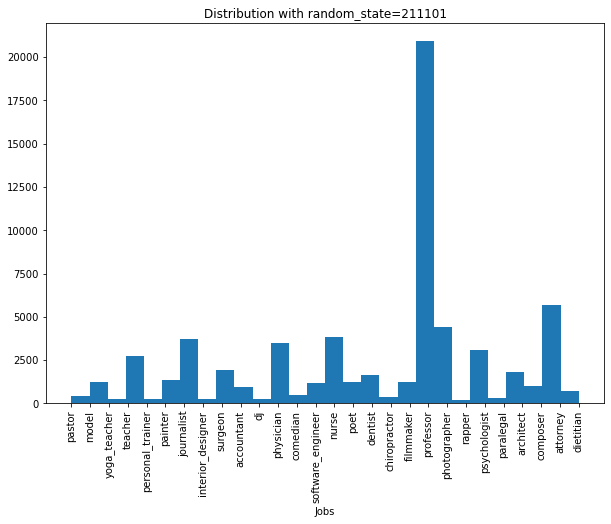

In [4]:
plt.figure(figsize=(10, 7))
plt.hist(data['Category'], 28)
plt.title("Distribution with random_state=211101")
plt.xlabel("Jobs")
plt.xticks(ticks = range(28), labels = category['0'], rotation = 'vertical')
plt.show()

### Méthode de preprocessing des extraits de CV

Méthode permettant le prérocessing des extratis de CV. 

In [5]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, number=False, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    ## remove number
    if not number:
        text = re.sub('[0-9]+', '', text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.SnowballStemmer("english")
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taver\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Appliquer la fonction à la liste des extraits de CV

In [7]:
nltk.download('wordnet')
data_clean = data
data_clean["description_clean"] = data_clean["description"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, number=True, lst_stopwords=lst_stopwords))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\taver\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
data_clean.drop(['description', 'gender', 'Id'], axis=1)

,Category,description_clean
189320,19,work crossdisciplinary combination art science...
206083,9,joined viking fishing 1996 financial manager r...
147304,3,dubbed teacher teacher trained top teacher yog...
153829,19,obtained undergraduate degree vanderbilt unive...
49631,6,last 15 year worked journalist correspondent z...
...,...,...
68380,20,passion capturing feeling moment photograph gi...
179477,19,teach organizational behaviour crosscultural m...
18694,20,yorkshire born birmingham living abigail curre...
115975,19,specializes queer theory transgender study wel...


## Word2Vec

Tout d'abord, on charge le model Word2Vec. Il a été pré-formé par Google sur un corpus Google News de 100 milliards de mots.

In [9]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

wv = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\taver\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

On peut observer une partie de ce vocabulaire.

In [11]:
from itertools import islice
from gensim import matutils
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

On utilise une fonction qui permet de faire la moyenne des deux vecteurs de mots.

In [12]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

Tokenization du texte:

In [13]:
def w2v_tokenize_text(text):
    tokens = []
    # For each sentence in the text
    for sent in nltk.sent_tokenize(text, language='english'):
        # For each words in the text
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [19]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=211101)

In [20]:
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['description_clean']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['description_clean']), axis=1).values

In [21]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

<ipython-input-12-be2991ec905f>:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  mean.append(wv.syn0norm[wv.vocab[word].index])


In [22]:
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=100)
logreg.fit(X_train_word_average, train['Category'])

print('Train: ', logreg.score(X_train_word_average, train['Category']))
print('Test: ', logreg.score(X_test_word_average, test['Category']))


Train:  0.7747424559249525
Test:  0.7460865561694291


c:\users\taver\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Doc2vec

In [23]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled


X_train, X_test, y_train, y_test = train_test_split(data_clean['description_clean'], data_clean["Category"], random_state=211101, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

c:\users\taver\appdata\local\programs\python\python38\lib\site-packages\tqdm\std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [24]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 65159/65159 [00:00<00:00, 3216049.31it/s]


In [25]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')


In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
print('Train: ', logreg.score(train_vectors_dbow, y_train))
print('Test: ', logreg.score(test_vectors_dbow, y_test))